In [83]:
import re
from enum import Enum
from typing import List, Tuple, Dict, Set, Optional, Union, Any, Callable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [84]:
def replace_multiple_spaces_by_one(s):
    return re.sub(r" +", " ", s)

In [85]:
class Unit(Enum):
    ns = 1000000000
    us = 1000000
    ms = 1000
    s = 1

    def __str__(self):
        return self.name

def get_unit(s):
    unit = s.replace("/op", "")
    if unit == "ns":
        return Unit.ns
    elif unit == "us":
        return Unit.us
    elif unit == "ms":
        return Unit.ms
    elif unit == "s":
        return Unit.s
    else:
        raise Exception("Unknown unit")
    
def convert(n:float, current_unit:Unit, new_unit:Unit) -> float:
    return n * current_unit.value / new_unit.value

def verify_unit_or_convert(data: Tuple[Unit, List[Tuple[int, float, float]]], other_data: Tuple[Unit, List[Tuple[int, float, float]]] = ()) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    unit = data[0] if other_data == () else other_data[0]
    u = data[0]
    res = [(x, convert(avg, u, unit), convert(err, u, unit)) for x, avg, err in data[1]]
    res.sort()
    return (unit, res)

In [86]:

def plot_data(data1: Tuple[Unit, List[Tuple[int, float, float]]], data1_name: str, data2: Tuple[Unit, List[Tuple[int, float, float]]], data2_name: str):
    unit1, dat1 = data1
    unit2, dat2 = data2
    assert unit1 == unit2
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot([x for x, _, _ in dat1], [y for _, y, _ in dat1], label=data1_name)
    ax.plot([x for x, _, _ in dat2], [y for _, y, _ in dat2], label=data2_name)
    ax.xlabel("Number of elements")
    ax.ylabel(f"Time ({unit1})")

    ax.legend()
    ax.show()

In [87]:
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional

def plot_data_with_error(plot_name: str,
                         data: Dict[str, Tuple[str, List[Tuple[int, float, float]]]],
                          x_line_at: int = 0, 
                          show_avg: bool = False, 
                          output_folder = ""):
    final_unit = None
    data_without_units: Dict[str, List[Tuple[int, float, float]]]= {}
    for name, (unit, dat) in data.items():
        data_without_units[name] = dat
        if final_unit is not None:
            assert final_unit == unit
        else:
            final_unit = unit
    
    assert len(data.keys()) <= 8


    fig, ax = plt.subplots()

    # Choose colorblind-friendly colors
    colours = ['tab:blue', 'tab:green', 'xkcd:barbie pink', 'tab:cyan', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    colorBlack = 'black'

    line_styles = ['-', '--', '-.', ':']
    markers=['.', 'x', '_', '^', '*', '<', '>', 'p', 'h', 'H', 'D', 'd', 'P', 'X']

    # the error bar is shown in another color, and it the 99% CI
    # The y-axis always starts at 0
    for i, (name, dat) in enumerate(data_without_units.items()):
        ax.errorbar([x for x, _, _ in dat], [y for _, y, _ in dat], yerr=[y for _, _, y in dat], label=name, ecolor=colorBlack, elinewidth=0.8, capsize=2, capthick=0.8, color=colours[i % len(colours)], marker=markers[i % len(markers)], linestyle=line_styles[i % len(line_styles)])

    avgs = {}
    for name, dat in data_without_units.items():
        avgs[name] = sum([y for _, y, _ in dat]) / len(dat) if len(dat) > 0 else 0

    max_y_value = max([y for l in data_without_units.values() for _, y, _ in l])

    max_y_value = max_y_value + 0.15 * max_y_value
    ax.set_xlabel("N")
    ax.set_ylabel(f"Time ({final_unit})")

    # Add a vertical line at x = x_line_at if not 0
    if x_line_at != 0:
        ax.axvline(x=x_line_at, color=colorBlack, linestyle='--')

    if show_avg:
        for name, avg in avgs.items():
            ax.axhline(y=avg, color=colours[list(avgs.keys()).index(name)], linestyle='--')

    ax.legend()
    ax.set_title(plot_name)
    
    if output_folder != "":
        # fig.savefig(f"{output_folder}/{plot_name}.png", format='png', dpi=1200)
        file_name = plot_name.replace(" - ", "_").replace(" ", "_").replace("^", "to").replace("&", "and").replace(",", "").replace("(", "").replace(")", "").replace(":", "").replace("/", "_")
        fig.savefig(f"{output_folder}/{file_name}.eps", format='eps')

    plt.show()


In [88]:
def extract_data(df: pd.DataFrame , benchmark_name: str, map_type_name: str, x_var_name: str) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    benchmark_name = f"{benchmark_name}_{map_type_name}"
    data = df[df["Benchmark"].str.contains(benchmark_name)]
    unit = get_unit(df["Units"].to_list()[0])
    return (unit, [(int(param), float(avg), float(err)) for param, avg, err in data[[f"({x_var_name})", "Score", "Error"]].to_numpy()])

def extract_data_normalised_per_op(df: pd.DataFrame , benchmark_name: str, map_type_name: str, x_var_name: str) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    benchmark_name = f"{benchmark_name}_{map_type_name}"
    data = df[df["Benchmark"].str.contains(benchmark_name)]
    unit = get_unit(df["Units"].to_list()[0])
    return (unit, [(int(param), float(avg)/float(param), float(err)/float(param) ) for param, avg, err in data[[f"({x_var_name})", "Score", "Error"]].to_numpy() if int(param) != 0] )


In [89]:
def create_plots(benchmark_classes: List[str], benchmark_names: Dict[str, List[str]], df: pd.DataFrame, variable_names: Dict[str, str] = {}, show_avg_for: str = "never", output_folder = ""):
    for c in benchmark_classes:
        benchmark_func_names = benchmark_names[c]
        for n in benchmark_func_names:
            if variable_names != {}:
                variable_name = variable_names[c]
            else:
                # Only for legacy reasons
                variable_name = "n" if "LongListMapBenchmark" in c else "keysListName"
            map1_name = "ArrayFill"
            map2_name = "EfficientFill"
            map3_name = "Constructor"
            benchm_name = f"{c}.{n}"
            bench_name_pretty = f"{n}"
            map1_data = verify_unit_or_convert(extract_data(df, benchm_name, map1_name, variable_name))
            map2_data = verify_unit_or_convert(extract_data(df, benchm_name, map2_name, variable_name), map1_data)
            map3_data = verify_unit_or_convert(extract_data(df, benchm_name, map3_name, variable_name), map1_data)
            x_line_at = 0
            data = {}
            data[map1_name] = map1_data
            data[map2_name] = map2_data
            data[map3_name] = map3_data
            if "fillValueCell" in benchmark_func_names:
                map4_name = "JavaArraysFill"
                map4_data = verify_unit_or_convert(extract_data(df, benchm_name, map4_name, variable_name), map1_data)
                data[map4_name] = map4_data


            plot_data_with_error(bench_name_pretty, data, x_line_at, show_avg_for == "always", output_folder)


# Array.fill Benchmark

In [90]:
data = """[info] Benchmark                                         (size)  Mode  Cnt       Score        Error  Units
[info] ArrayFillBenchmark.fillLong_ArrayFill                  2  avgt   10       0.016 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                  4  avgt   10       0.019 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                  8  avgt   10       0.023 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                 16  avgt   10       0.026 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                 32  avgt   10       0.036 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                 64  avgt   10       0.079 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                128  avgt   10       0.213 ±      0.002  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                256  avgt   10       0.346 ±      0.005  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                512  avgt   10       0.624 ±      0.004  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill               1024  avgt   10       1.159 ±      0.008  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill               2048  avgt   10       2.238 ±      0.023  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill               4096  avgt   10       4.484 ±      0.055  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill               8192  avgt   10       9.683 ±      0.089  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill              16384  avgt   10      28.618 ±      0.276  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill              32768  avgt   10      57.783 ±      3.849  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill              65536  avgt   10     119.581 ±      0.467  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill             131072  avgt   10     239.810 ±      1.969  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill             262144  avgt   10     478.680 ±      3.356  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill             524288  avgt   10     955.573 ±      5.168  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill            1048576  avgt   10    1901.079 ±     22.581  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill            2097152  avgt   10    4049.381 ±     36.796  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill            4194304  avgt   10    9644.231 ±    145.255  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill            8388608  avgt   10   19763.064 ±    131.081  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill           16777216  avgt   10   39103.775 ±    217.167  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill           33554432  avgt   10   78407.305 ±    387.083  us/op
[info] ArrayFillBenchmark.fillLong_Constructor                2  avgt   10       0.010 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_Constructor                4  avgt   10       0.011 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_Constructor                8  avgt   10       0.014 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_Constructor               16  avgt   10       0.016 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_Constructor               32  avgt   10       0.030 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_Constructor               64  avgt   10       0.070 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_Constructor              128  avgt   10       0.166 ±      0.002  us/op
[info] ArrayFillBenchmark.fillLong_Constructor              256  avgt   10       0.290 ±      0.002  us/op
[info] ArrayFillBenchmark.fillLong_Constructor              512  avgt   10       0.536 ±      0.008  us/op
[info] ArrayFillBenchmark.fillLong_Constructor             1024  avgt   10       1.016 ±      0.012  us/op
[info] ArrayFillBenchmark.fillLong_Constructor             2048  avgt   10       1.982 ±      0.008  us/op
[info] ArrayFillBenchmark.fillLong_Constructor             4096  avgt   10       3.915 ±      0.030  us/op
[info] ArrayFillBenchmark.fillLong_Constructor             8192  avgt   10       7.867 ±      0.061  us/op
[info] ArrayFillBenchmark.fillLong_Constructor            16384  avgt   10      22.977 ±      0.245  us/op
[info] ArrayFillBenchmark.fillLong_Constructor            32768  avgt   10      45.672 ±      0.477  us/op
[info] ArrayFillBenchmark.fillLong_Constructor            65536  avgt   10      94.492 ±      0.428  us/op
[info] ArrayFillBenchmark.fillLong_Constructor           131072  avgt   10     190.183 ±      2.019  us/op
[info] ArrayFillBenchmark.fillLong_Constructor           262144  avgt   10     381.846 ±      2.149  us/op
[info] ArrayFillBenchmark.fillLong_Constructor           524288  avgt   10     771.592 ±      5.444  us/op
[info] ArrayFillBenchmark.fillLong_Constructor          1048576  avgt   10    1534.706 ±      8.060  us/op
[info] ArrayFillBenchmark.fillLong_Constructor          2097152  avgt   10    3070.874 ±     18.249  us/op
[info] ArrayFillBenchmark.fillLong_Constructor          4194304  avgt   10    6096.058 ±     67.920  us/op
[info] ArrayFillBenchmark.fillLong_Constructor          8388608  avgt   10   12158.157 ±     80.916  us/op
[info] ArrayFillBenchmark.fillLong_Constructor         16777216  avgt   10   24266.877 ±    175.219  us/op
[info] ArrayFillBenchmark.fillLong_Constructor         33554432  avgt   10   48460.159 ±    584.859  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill              2  avgt   10       0.012 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill              4  avgt   10       0.015 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill              8  avgt   10       0.018 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill             16  avgt   10       0.021 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill             32  avgt   10       0.032 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill             64  avgt   10       0.075 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill            128  avgt   10       0.183 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill            256  avgt   10       0.337 ±      0.002  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill            512  avgt   10       0.617 ±      0.011  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill           1024  avgt   10       1.159 ±      0.010  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill           2048  avgt   10       2.217 ±      0.020  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill           4096  avgt   10       4.460 ±      0.052  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill           8192  avgt   10       9.661 ±      0.080  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill          16384  avgt   10      28.516 ±      0.256  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill          32768  avgt   10      57.828 ±      3.966  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill          65536  avgt   10     119.179 ±      1.268  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill         131072  avgt   10     238.801 ±      1.681  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill         262144  avgt   10     480.945 ±      4.273  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill         524288  avgt   10     958.040 ±      5.104  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill        1048576  avgt   10    1880.480 ±     16.620  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill        2097152  avgt   10    4131.106 ±    392.361  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill        4194304  avgt   10    9577.909 ±     65.139  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill        8388608  avgt   10   19504.889 ±    115.797  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill       16777216  avgt   10   39190.370 ±    300.139  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill       33554432  avgt   10   78065.356 ±    395.334  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill             2  avgt   10       0.023 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill             4  avgt   10       0.029 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill             8  avgt   10       0.041 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill            16  avgt   10       0.068 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill            32  avgt   10       0.121 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill            64  avgt   10       0.240 ±      0.002  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill           128  avgt   10       0.404 ±      0.003  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill           256  avgt   10       0.839 ±      0.014  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill           512  avgt   10       1.668 ±      0.011  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill          1024  avgt   10       3.213 ±      0.033  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill          2048  avgt   10       6.408 ±      0.150  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill          4096  avgt   10      12.629 ±      0.165  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill          8192  avgt   10      25.118 ±      0.161  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill         16384  avgt   10      52.208 ±      0.510  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill         32768  avgt   10     105.141 ±      0.847  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill         65536  avgt   10     210.076 ±      1.619  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill        131072  avgt   10     428.782 ±      7.861  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill        262144  avgt   10     881.329 ±     27.076  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill        524288  avgt   10    1709.255 ±     29.879  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill       1048576  avgt   10   19695.626 ±   1506.429  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill       2097152  avgt   10   38928.163 ±   3396.531  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill       4194304  avgt   10   69428.328 ±  10960.259  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill       8388608  avgt   10  139429.346 ±  15216.519  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill      16777216  avgt   10  280637.362 ±  32564.008  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill      33554432  avgt   10  552834.233 ±  47141.798  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor           2  avgt   10       0.010 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor           4  avgt   10       0.010 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor           8  avgt   10       0.011 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor          16  avgt   10       0.015 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor          32  avgt   10       0.017 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor          64  avgt   10       0.030 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor         128  avgt   10       0.070 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor         256  avgt   10       0.163 ±      0.002  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor         512  avgt   10       0.291 ±      0.002  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor        1024  avgt   10       0.535 ±      0.005  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor        2048  avgt   10       1.020 ±      0.006  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor        4096  avgt   10       1.980 ±      0.015  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor        8192  avgt   10       3.899 ±      0.030  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor       16384  avgt   10       7.904 ±      0.068  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor       32768  avgt   10      22.997 ±      0.148  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor       65536  avgt   10      46.021 ±      0.394  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor      131072  avgt   10      95.165 ±      1.216  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor      262144  avgt   10     189.869 ±      0.975  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor      524288  avgt   10     381.718 ±      2.376  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor     1048576  avgt   10    2347.187 ±     74.391  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor     2097152  avgt   10    4599.420 ±     81.571  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor     4194304  avgt   10    9303.122 ±    524.904  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor     8388608  avgt   10   20620.590 ±   1339.736  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor    16777216  avgt   10   32817.338 ±  11900.853  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor    33554432  avgt   10   69280.938 ±  14876.148  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill         2  avgt   10       0.016 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill         4  avgt   10       0.020 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill         8  avgt   10       0.027 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill        16  avgt   10       0.041 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill        32  avgt   10       0.070 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill        64  avgt   10       0.121 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill       128  avgt   10       0.201 ±      0.002  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill       256  avgt   10       0.450 ±      0.002  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill       512  avgt   10       0.851 ±      0.005  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill      1024  avgt   10       1.675 ±      0.012  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill      2048  avgt   10       3.330 ±      0.021  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill      4096  avgt   10       6.670 ±      0.052  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill      8192  avgt   10      13.339 ±      0.070  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill     16384  avgt   10      31.511 ±      0.206  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill     32768  avgt   10      81.233 ±      0.916  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill     65536  avgt   10     163.308 ±      1.404  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill    131072  avgt   10     328.494 ±      1.899  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill    262144  avgt   10     655.404 ±      5.893  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill    524288  avgt   10    1265.070 ±    142.765  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill   1048576  avgt   10   16463.945 ±    500.801  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill   2097152  avgt   10   30959.558 ±  29409.943  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill   4194304  avgt   10   54567.450 ±  21436.476  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill   8388608  avgt   10  100337.175 ±  38762.942  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill  16777216  avgt   10  209281.584 ±  78383.206  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill  33554432  avgt   10  410097.781 ± 173592.925  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill         2  avgt   10       0.016 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill         4  avgt   10       0.020 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill         8  avgt   10       0.026 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill        16  avgt   10       0.044 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill        32  avgt   10       0.074 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill        64  avgt   10       0.122 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill       128  avgt   10       0.204 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill       256  avgt   10       0.450 ±      0.004  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill       512  avgt   10       0.863 ±      0.006  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill      1024  avgt   10       1.688 ±      0.010  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill      2048  avgt   10       3.387 ±      0.050  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill      4096  avgt   10       6.686 ±      0.042  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill      8192  avgt   10      13.323 ±      0.061  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill     16384  avgt   10      34.107 ±      0.567  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill     32768  avgt   10      80.629 ±      0.601  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill     65536  avgt   10     162.913 ±      1.322  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill    131072  avgt   10     331.879 ±      4.936  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill    262144  avgt   10     651.656 ±      5.241  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill    524288  avgt   10    1262.411 ±    103.213  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill   1048576  avgt   10   20389.018 ±   4221.972  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill   2097152  avgt   10   35265.968 ±  50402.872  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill   4194304  avgt   10   56355.970 ±  26535.419  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill   8388608  avgt   10  109079.008 ±  64867.390  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill  16777216  avgt   10  200608.578 ±  61453.594  us/op
[info] ArrayFillBenchmark.fillValueCell_JavaArraysFill  33554432  avgt   10  392149.018 ± 124931.197  us/op""".strip().split("\n")


data = [replace_multiple_spaces_by_one(s.replace("[info]", "").replace("±", "")).replace(" ", ",") for s in data]
# create a panda dataframe from the data, using the first line as the column names
df = pd.DataFrame([s.split(",") for s in data[1:]], columns=data[0].split(","))
benchmark_classes = ["ArrayFillBenchmark"]

benchmark_names = {}
for n in benchmark_classes:
    benchmark_mutable_map_names = df["Benchmark"].unique().tolist()
    benchmark_mutable_map_names = [s.replace(f"{n}.", "") for s in benchmark_mutable_map_names if f"{n}." in s]
    benchmark_mutable_map_names = [s.replace("_ArrayFill", "").replace("_EfficientFill", "").replace("_Constructor", "").replace("_JavaArraysFill", "") for s in benchmark_mutable_map_names]
    # remove duplicates
    benchmark_mutable_map_names = list(set(benchmark_mutable_map_names))
    benchmark_names[n] = benchmark_mutable_map_names
benchmark_names

variable_names = {}
for n in benchmark_classes:
    variable_names[n] = "size"

variable_names

{'ArrayFillBenchmark': 'size'}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


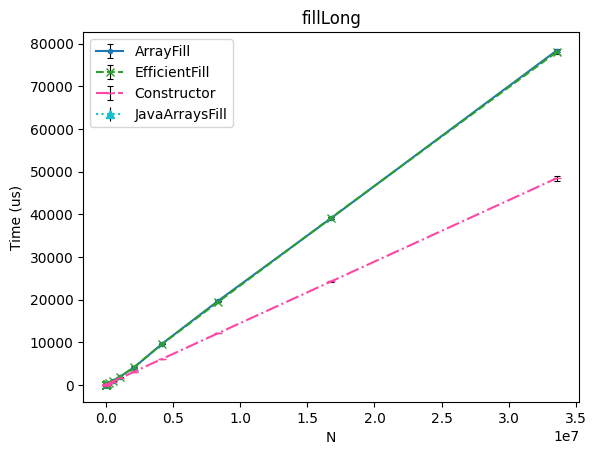

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


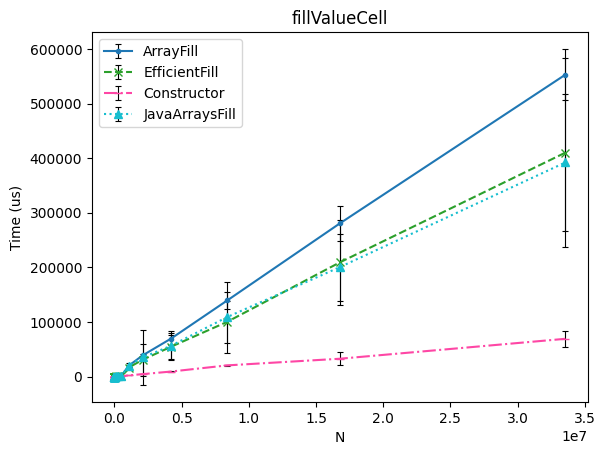

In [91]:
create_plots(benchmark_classes, benchmark_names, df, variable_names, show_avg_for="normalised", output_folder="./plots")